# Lugge glacier 2D 

This notebook uses the RGI outline to mesh Lugge Glacier, and then interpolates several datasets onto the mesh (elevation, thickness, surface mass balance).  

## Imports

In [1]:
import icepack, icepack.plot, icepack.meshing
from firedrake import *
import geopandas as gpd
import geojson
from geojson.utils import coords
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import pandas as pd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.interpolate import griddata, interp1d
from shapely.geometry import shape, Polygon, MultiPolygon, LineString

## Set paths

In [2]:
base_path = '/eejit/home/bezu0001/'
shapefile_path = base_path + 'data/outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
dem_path = base_path + 'data/elevation/DEM-SRTMv3/SRTMv3_RGI60-15-02373.tif'
thickness_path = base_path + 'data/bed/Thickness-Farinotti/RGI60-15-02373_latlon.tif'
smb_path = base_path + 'data/smb/prf_glacier_ctl.csv'
mesh_path = base_path + 'icepack/meshes/'
velocity_path = base_path + 'data/velocity/lugge/MedianVelocity_2006.tif'
centerline_path = base_path + 'data/centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'data/outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'

## RGI outline

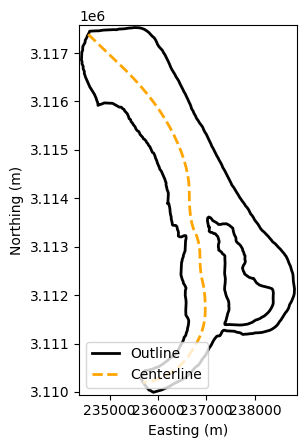

In [3]:
# --- Load and project outlines + centerlines ---
lugge_id = "15-09534"
lugge_gdf = gpd.read_file(shapefile_path).query(f"rgi_id.str.contains('{lugge_id}')", engine="python")
utm_crs = lugge_gdf.estimate_utm_crs()
lugge_gdf = lugge_gdf.to_crs(utm_crs)
lugge_geojson = geojson.loads(lugge_gdf.to_json())


outline_gdf = gpd.read_file(outline_path).to_crs(lugge_gdf.crs)
centerlines = gpd.read_file(centerline_path).to_crs(lugge_gdf.crs)
lugge_outline = outline_gdf.query(f"rgi_id.str.contains('{lugge_id}')", engine="python").geometry.values[0]
lugge_centerline = centerlines[centerlines.intersects(lugge_outline)].geometry.values[0]

# --- Simplify geometry coordinates ---
def decimate(ring, step=1):
    return ring[::step] if len(ring) >= 4 else ring

for feat in lugge_geojson["features"]:
    geom = feat["geometry"]
    if geom["type"] == "Polygon":
        geom["coordinates"] = [decimate(geom["coordinates"][0])] + [decimate(r) for r in geom["coordinates"][1:]]
    elif geom["type"] == "MultiPolygon":
        geom["coordinates"] = [
            [decimate(p[0])] + [decimate(r) for r in p[1:]]
            for p in geom["coordinates"]
        ]

# --- Bounding box ---
δ = 50
all_coords = np.array(list(coords(lugge_geojson)))
xmin, xmax = all_coords[:, 0].min() - δ, all_coords[:, 0].max() + δ
ymin, ymax = all_coords[:, 1].min() - δ, all_coords[:, 1].max() + δ

# --- Plot ---
fig, ax = plt.subplots()
outline_drawn = False
for feat in lugge_geojson["features"]:
    rings = feat["geometry"]["coordinates"]
    if feat["geometry"]["type"] == "Polygon":
        rings = [rings]
    for poly in rings:
        for i, ring in enumerate(poly):
            ring = np.array(ring)
            label = "Outline" if not outline_drawn and i == 0 else None
            ax.plot(ring[:, 0], ring[:, 1], color="black", linewidth=2, label=label)
            outline_drawn = True

# Plot centerline
x, y = lugge_centerline.xy
ax.plot(x, y, color="orange", linestyle="--", linewidth=2, label="Centerline")

# Final touches
ax.set_aspect("equal")
ax.set(xlabel="Easting (m)", ylabel="Northing (m)", xlim=(xmin, xmax), ylim=(ymin, ymax))
ax.legend(loc="lower left")
plt.show()

## Segmenting Glacier Outline and Internal Holes

This cell processes the Lugge Glacier outline data by:
- Extracting the exterior boundaries and interior holes from the GeoJSON geometry.
- Subdividing each exterior boundary into segments containing 10 points each.
- Constructing `GeoDataFrame` objects for both the exterior segments and interior rings.
- Concatenating the two into a single `GeoDataFrame` (`full_gdf`) that contains all line features for use in mesh generation or analysis.

In [4]:
# --- Extract exterior and interior boundaries ---
geom_all = [shape(f["geometry"]) for f in lugge_geojson["features"]]
polys = [g for geom in geom_all for g in (geom.geoms if isinstance(geom, MultiPolygon) else [geom])]

exterior_lines = [LineString(p.exterior.coords) for p in polys]
interior_rings = [LineString(r.coords) for p in polys for r in p.interiors]

print(f"Extracted {len(exterior_lines)} exterior boundary line(s)")
print(f"Extracted {len(interior_rings)} interior hole(s)")

# --- Subdivide exterior lines ---
N = 10
segments = [
    (f"segment_{i}_{j}", LineString(line.coords[j:j+N]))
    for i, line in enumerate(exterior_lines)
    for j in range(0, len(line.coords), N)
    if len(line.coords[j:j+N]) > 1
]

# --- Create GeoDataFrames ---
seg_gdf = gpd.GeoDataFrame(
    {"id": [sid for sid, _ in segments], "geometry": [geom for _, geom in segments]},
    crs=lugge_gdf.crs
)

holes_gdf = gpd.GeoDataFrame(
    {"id": [f"hole_{i}" for i in range(len(interior_rings))], "geometry": interior_rings},
    crs=lugge_gdf.crs
)

# --- Combine all segments ---
full_gdf = pd.concat([seg_gdf, holes_gdf], ignore_index=True)
print(f"Combined GeoDataFrame has {len(full_gdf)} features.")


Extracted 1 exterior boundary line(s)
Extracted 1 interior hole(s)
Combined GeoDataFrame has 49 features.


# Mesh the result, and plot

PETSc Error --- Application was linked against both OpenMPI and MPICH based MPI libraries and will not run correctly


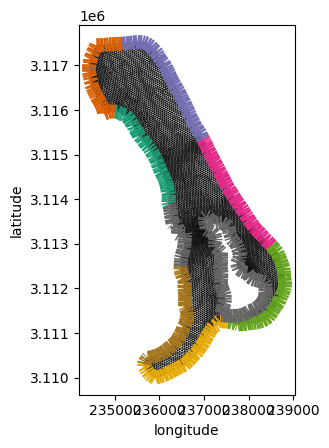

In [5]:
# Convert full_gdf to GeoJSON FeatureCollection
full_geojson = geojson.loads(full_gdf.to_json())

# Now pass this to collection_to_gmsh
gmsh_mesh = icepack.meshing.collection_to_gmsh(full_geojson)
gmsh_mesh.write(mesh_path + 'lugge.msh', verbose=False)
mesh = firedrake.Mesh(mesh_path + 'lugge.msh')
mesh_path += 'lugge.msh'

# Create the plot
fig, axes = plt.subplots()
axes.set_xlabel("longitude")
axes.set_ylabel("latitude")

kwargs = {
    "interior_kw": {"linewidth": 0.25},   # Thin lines for interior edges
    "boundary_kw": {"linewidth": 10},      # Thicker lines for boundary segments
}
triplot(mesh, axes=axes, **kwargs)

axes.set_aspect('equal')  # Ensure equal aspect ratio
# axes.legend(loc="upper right", fontsize = 8)
plt.show()

## DEM

<Figure size 800x600 with 0 Axes>

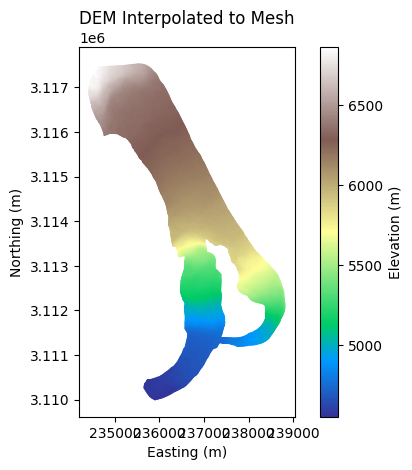

In [6]:
# --- Reproject DEM to glacier CRS ---
with rasterio.open(dem_path) as src:
    transform, width, height = calculate_default_transform(src.crs, utm_crs.to_string(), src.width, src.height, *src.bounds)

    dem_array = np.empty((height, width), dtype=src.read(1).dtype)
    reproject(
        src.read(1), dem_array,
        src_transform=src.transform, src_crs=src.crs,
        dst_transform=transform, dst_crs=utm_crs.to_string(),
        resampling=Resampling.bilinear
    )
    dem_array = np.where(dem_array == src.nodata, np.nan, dem_array)

# --- Interpolate DEM to mesh ---
rows, cols = np.indices(dem_array.shape)
x, y = rasterio.transform.xy(transform, rows, cols, offset="center")
points = np.column_stack((np.array(x).ravel(), np.array(y).ravel()))
values = dem_array.ravel()

vertex_coords = np.array(mesh.coordinates.dat.data_ro)
Q = FunctionSpace(mesh, "CG", 1)
dem = Function(Q)
dem.dat.data[:] = griddata(points, values, vertex_coords, method="linear", fill_value=np.nan)

# --- Plot ---
plt.figure(figsize=(8, 6))
tpc = tripcolor(dem, cmap="terrain")
plt.title("DEM Interpolated to Mesh")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(tpc, label="Elevation (m)")
plt.gca().set_aspect("equal")
plt.show()

## Thickness/bed data

<Figure size 800x600 with 0 Axes>

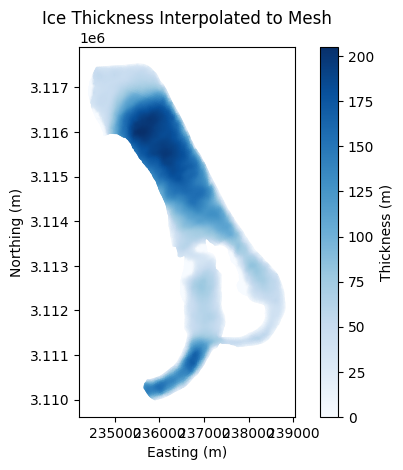

In [7]:
# --- Reproject and interpolate thickness to mesh ---
with rasterio.open(thickness_path) as src:
    transform, width, height = calculate_default_transform(src.crs, utm_crs.to_string(), src.width, src.height, *src.bounds)

    arr = np.empty((height, width), dtype=src.read(1).dtype)
    reproject(
        src.read(1), arr,
        src_transform=src.transform, src_crs=src.crs,
        dst_transform=transform, dst_crs=utm_crs.to_string(),
        resampling=Resampling.bilinear
    )
    arr = np.where(arr == src.nodata, np.nan, arr)

rows, cols = np.indices(arr.shape)
x, y = rasterio.transform.xy(transform, rows, cols, offset="center")
points = np.column_stack((np.array(x).ravel(), np.array(y).ravel()))
values = arr.ravel()

thickness = Function(Q)
thickness.dat.data[:] = griddata(points, values, vertex_coords, method="linear", fill_value=np.nan)

# --- Plot ---
plt.figure(figsize=(8, 6))
tpc = tripcolor(thickness, cmap="Blues")
plt.title("Ice Thickness Interpolated to Mesh")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(tpc, label="Thickness (m)")
plt.gca().set_aspect("equal")
plt.show()

## Velocity maps

<Figure size 800x600 with 0 Axes>

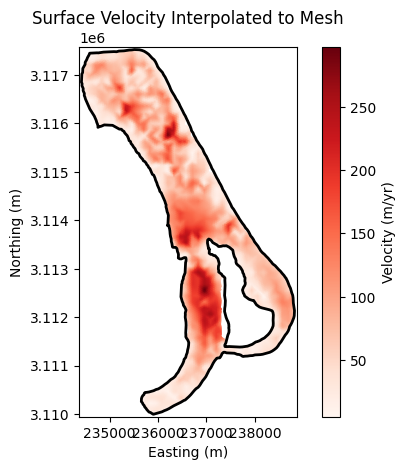

In [8]:
# --- Reproject and interpolate surface velocity ---
with rasterio.open(velocity_path) as src:
    transform, width, height = calculate_default_transform(src.crs, utm_crs.to_string(), src.width, src.height, *src.bounds)

    arr = np.empty((height, width), dtype=src.read(1).dtype)
    reproject(
        src.read(1), arr,
        src_transform=src.transform, src_crs=src.crs,
        dst_transform=transform, dst_crs=utm_crs.to_string(),
        resampling=Resampling.bilinear
    )
    arr = np.where(arr == src.nodata, np.nan, arr)

rows, cols = np.indices(arr.shape)
x, y = rasterio.transform.xy(transform, rows, cols, offset="center")
points = np.column_stack((np.array(x).ravel(), np.array(y).ravel()))
values = arr.ravel()

velocity = Function(Q)
velocity.dat.data[:] = griddata(points, values, vertex_coords, method="linear", fill_value=np.nan)

# --- Plot ---
plt.figure(figsize=(8, 6))
tpc = tripcolor(velocity, cmap="Reds")
plt.title("Surface Velocity Interpolated to Mesh")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(tpc, label="Velocity (m/yr)")
plt.gca().set_aspect("equal")

# Overlay outline
for f in lugge_geojson["features"]:
    geom = f["geometry"]
    rings = geom["coordinates"] if geom["type"] == "Polygon" else [r for poly in geom["coordinates"] for r in poly]
    for ring in rings:
        ring = np.array(ring)
        plt.plot(ring[:, 0], ring[:, 1], color="black", linewidth=2)

plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
plt.show()

## Surface mass balance

<Figure size 800x600 with 0 Axes>

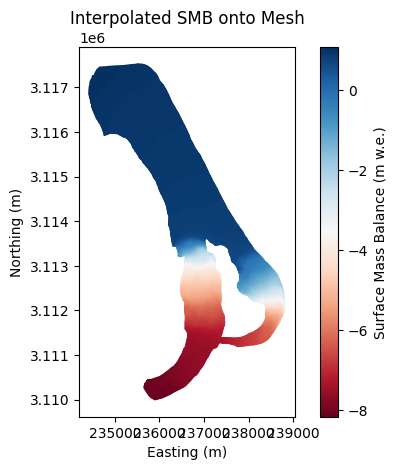

In [9]:
# --- Interpolate Surface Mass Balance (SMB) onto mesh ---
smb_df = pd.read_csv(smb_path)
smb_interp = interp1d(smb_df[' altitude'].values, smb_df['ave_mb'].values, bounds_error=False, fill_value=np.nan)
smb = Function(Q)
smb.dat.data[:] = smb_interp(dem.dat.data_ro)

# --- Plot ---
plt.figure(figsize=(8, 6))
tpc = tripcolor(smb, cmap='RdBu', shading='gouraud')
plt.colorbar(tpc, label="Surface Mass Balance (m w.e.)")
plt.gca().set_aspect('equal')
plt.title("Interpolated SMB onto Mesh")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

# Part 2: Modeling

In [10]:
import icepack, icepack2
from icepack.constants import ice_density as ρ_I, gravity as g
from icepack.utilities import itemgetter
from icepack2 import model
import tqdm

## Material parameters etc.

In [11]:
T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
H = thickness.copy(deepcopy = True)
s = dem.copy(deepcopy = True)

V = VectorFunctionSpace(mesh, 'CG', 1)
x, y = firedrake.SpatialCoordinate(Q)
u = Function(V).project(as_vector((0, -12.46)))

u_0 = u.copy(deepcopy = True)
H_0 = H.copy(deepcopy = True)
s_0 = s.copy(deepcopy = True)
bed = Function(Q).project(s_0 - H_0)

## Initialize model

In [12]:
opts = {
    'dirichlet_ids' : [13, 14],
}

flow_model = icepack.models.ShallowIce()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Solve the SIA iteratively

In [13]:
Δt = 1/10
num_years = 10
num_timesteps = int(num_years/Δt)

for step in tqdm.trange(num_timesteps):
    
    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = Constant(0))
    s.project(bed + H)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]


## Plot 2D results

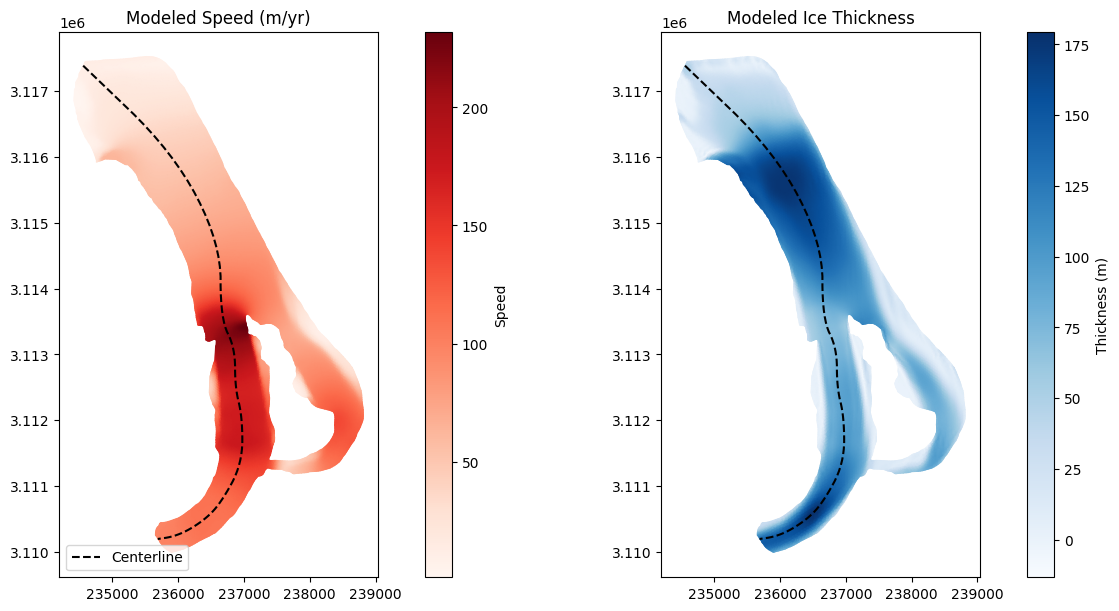

In [14]:
modeled_speed = Function(Q).project(sqrt(u[0]**2 + u[1]**2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Speed subplot
ax1.set_title("Modeled Speed (m/yr)")
ax1.set_aspect('equal')
speed_plot = tripcolor(modeled_speed, axes=ax1, cmap='Reds')
fig.colorbar(speed_plot, ax=ax1, label="Speed")

# Thickness subplot
ax2.set_title("Modeled Ice Thickness")
ax2.set_aspect('equal')
thickness_plot = tripcolor(H, axes=ax2, cmap='Blues')
fig.colorbar(thickness_plot, ax=ax2, label="Thickness (m)")

# Plot centerline on both
x, y = lugge_centerline.xy  # Assumes lugge_centerline is a shapely LineString
ax1.plot(x, y, color='black', linewidth=1.5, linestyle='--', label="Centerline")
ax2.plot(x, y, color='black', linewidth=1.5, linestyle='--')

# Optional legend
ax1.legend(loc="lower left")

plt.show()

## Plot results along centerline

This allows better comparison with the flowline model

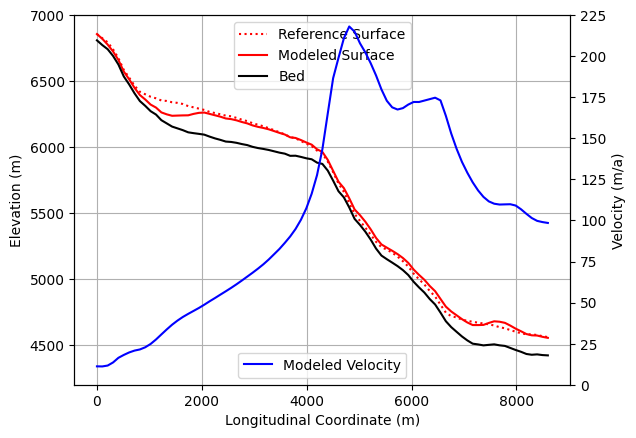

In [15]:
spacing = 100.0  # meters
n_points = int(np.floor(lugge_centerline.length / spacing))
sampled_pts = [lugge_centerline.interpolate(d) for d in np.linspace(0, lugge_centerline.length, n_points)]
centerline_coords = np.array([[pt.x, pt.y] for pt in sampled_pts])
distances = np.linspace(0, lugge_centerline.length, len(centerline_coords))

# --- Extract values along centerline ---
s0_vals = s_0.at(centerline_coords)
s_vals = s.at(centerline_coords)
bed_vals = bed.at(centerline_coords)
velocity_vals = modeled_speed.at(centerline_coords)

# --- Plot elevation and velocity profiles ---
fig, ax1 = plt.subplots()

# Elevation profiles
ax1.plot(distances, s0_vals, 'r:', label="Reference Surface")
ax1.plot(distances, s_vals, 'r-', label="Modeled Surface")
ax1.plot(distances, bed_vals, 'k-', label="Bed")
ax1.set_xlabel("Longitudinal Coordinate (m)")
ax1.set_ylabel("Elevation (m)")
ax1.set_ylim(4200, 7000)
ax1.grid(True)
ax1.legend(loc="upper center")

# Velocity profile
ax2 = ax1.twinx()
ax2.plot(distances, velocity_vals, 'b-', label="Modeled Velocity")
ax2.set_ylabel("Velocity (m/a)")
ax2.set_ylim(0, 225)
ax2.legend(loc="lower center")

plt.show()